# Ternary routing between experts
- The model resembles mixture of experts.
- Define expert networks that are small networks and they need to interact with networks up the hierarchy.
- The interaction is mediated by a routing matrix.

## Preliminary Experiment Design

### Design a ternary differentiable rule
- Using Trident framework, to be able to backprop through the ternary matrix of connectivity.

### Build a MoE model
- Experets of certain size talking across hierarchy.

### Test out with synthetic data
- Define random test inputs and labels.
- Assign them different penalty weights.

### Potential questions to ask
- Does the number of routing connections go up when the surprising/critical inputs are presented?
- What happens to the balance condition?


In [1]:
import jax
import jax.numpy as jnp
import flax
from flax import nnx

import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from collections import defaultdict

# Define the trident-ternary activation

In [2]:
def ternary_activation(x, thresholds, noise_sd, key):
    """
    Ternary activation function
    """
    # key, key2 = jax.random.split(key, 2)

    # generate noise
    noise = jax.random.normal(key = key, shape = x.shape) * noise_sd

    # inject noise
    x = x + noise


    # threshold
    t1, t2 = thresholds
    s = jnp.where(
        x < t1, -1.0,
        jnp.where(
            x > t2, 1.0,
            0.0
        )
    )

    return s

# helper function
@jax.jit
def gaussian_cdf(x, mu, sigma):
    return jax.scipy.stats.norm.cdf(x, loc = mu, scale = sigma)

@jax.jit
def gaussian_pdf(x, mu, sigma):
    return jax.scipy.stats.norm.pdf(x, loc = mu, scale = sigma)

@jax.jit
def expected_state(x, thresholds, noise_sd):
    t1, t2 = thresholds
    e = ((1 - gaussian_cdf(x = t2 - x, mu = 0, sigma = noise_sd)) - gaussian_cdf(x = t1 - x, mu = 0, sigma = noise_sd))
    return e

# custom gradients

@jax.custom_vjp
def trident(x, thresholds, noise_sd, key):
    return ternary_activation(x = x, thresholds = thresholds, noise_sd = noise_sd, key = key) # call the ternary activation in the forward pass

def trident_fwd(x, thresholds, noise_sd, key):
    return trident(x, thresholds, noise_sd, key), (x, thresholds, noise_sd) # save the inputs, thresholds, noise_sd for the backward pass

def trident_bwd(residuals, grads):
    x, thresholds, noise_sd = residuals # unpack the residuals from forward pass
    t1, t2 = thresholds
    exp_state_grad = gaussian_pdf(x = t1 - x, mu = 0, sigma = noise_sd) + gaussian_pdf(x = t2 - x, mu = 0, sigma = noise_sd)
    return (exp_state_grad*grads, None, None, None)

trident.defvjp(trident_fwd, trident_bwd)



Text(0, 0.5, 'Custom Gradient')

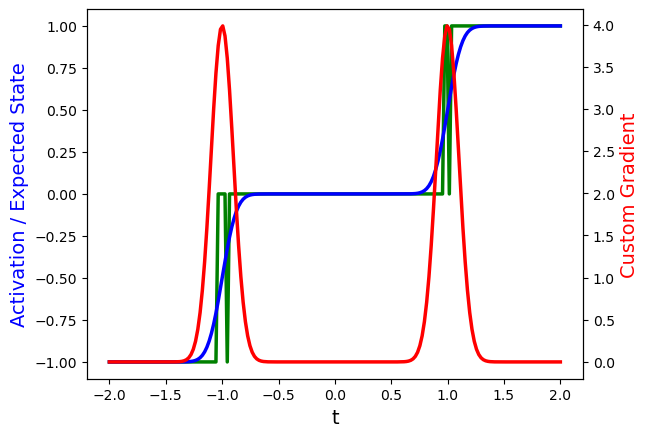

In [5]:
## testing
kk = jax.random.key(0)
t = jnp.linspace(-2, 2, 200)
th = [-1.0, 1.0]
noise_sd = 0.1
act = ternary_activation(t, th, 0.1, kk)
exp_st = expected_state(t, th, noise_sd)
cus_grad = jax.vmap(jax.grad(trident), in_axes=(0, None, None, None))(t, th, noise_sd, kk)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(t, act, 'g-', lw = 2.5)
ax1.plot(t, exp_st, 'b-', lw = 2.5)
ax2.plot(t, cus_grad, 'r-', lw = 2.5)

ax1.set_xlabel('t', fontsize = 14)
ax1.set_ylabel('Activation / Expected State', color='b', fontsize = 14)
ax2.set_ylabel('Custom Gradient', color='r', fontsize = 14)

In [7]:
## testing 2
key = jax.random.key(4562)
x_test = jax.random.normal(key, (10, 100))
th_test = [-0.5, 0.5]
noise_sd_test = 0.1
outs = jax.vmap(trident, in_axes=(0, None, None, None))(x_test, th_test, noise_sd_test, key)
print(outs.shape, "\n", outs)

(10, 100) 
 [[ 0. -1. -1.  0. -1. -1.  0. -1.  1.  0.  0. -1.  0.  1. -1. -1. -1. -1.
   1.  1. -1.  1.  1. -1. -1.  1. -1.  0.  1.  0. -1. -1.  0. -1.  1.  0.
   0.  0. -1.  1. -1.  0. -1.  1. -1. -1.  0. -1. -1. -1.  0. -1.  0. -1.
  -1.  1.  1. -1. -1.  1.  0.  0. -1.  1.  1.  0. -1.  0. -1.  1.  1. -1.
   1. -1. -1.  0.  0. -1.  0. -1.  0.  1. -1.  1.  1. -1.  1. -1. -1.  1.
  -1.  1.  0.  1. -1.  0.  0.  0. -1. -1.]
 [-1.  1. -1. -1.  0. -1.  0.  0. -1.  0.  0.  1.  0.  1. -1.  1. -1.  0.
   1.  1.  0.  0.  0. -1. -1. -1.  1. -1.  0.  0. -1.  1. -1.  0.  0.  1.
  -1. -1.  1. -1.  0.  0. -1.  1. -1.  0. -1.  1. -1.  1. -1. -1.  1. -1.
   0.  1.  0.  1.  1.  1.  0.  1.  1.  0.  1.  0. -1. -1. -1.  0. -1.  0.
   1.  0.  1.  1.  1.  1. -1.  0.  0.  1.  1. -1.  1.  0.  1. -1.  0.  0.
   1.  1.  0. -1.  1. -1. -1. -1.  1.  0.]
 [-1.  1.  0.  1.  0. -1. -1. -1.  0.  1. -1.  0.  0. -1.  0. -1. -1.  1.
  -1.  0.  1. -1. -1. -1.  0.  1.  0.  0.  0. -1. -1. -1. -1.  0.  1. -1.
   1.  0.  0. 